In [8]:
%load_ext autoreload
%autoreload 2

import pickle 
import torch as th
from torch_geometric.explain import Explainer, CaptumExplainer
import torch.nn.functional as F
import torch
from config import UQ_dtypes
import pandas as pd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


device(type='cpu')

### Preprocess Flows

In [9]:
import regex as re

print('preprocessing')

data = pd.read_csv('raw/ToN_v1_train_test_network.csv', dtype=UQ_dtypes)

# data = data.drop('ts', axis=1)
data = data[data.proto == 'tcp']
assert len(data) > 0
data.proto = data.proto.replace('tcp', 0)

src_ip_port = data.src_ip.astype(str) + ':' + data.src_port.astype(str)
data.insert(0, 'src_ip_port', src_ip_port)

dst_ip_port = data.dst_ip.astype(str) + ':' + data.dst_port.astype(str)
data.insert(1, 'dst_ip_port', dst_ip_port)

ip_src_type = data.src_ip.apply(lambda ip: 1 if (re.search('^10[.]', ip) or re.search('^172[.][1-3][678901][.]', ip) or re.search('^192[.]168[.]', ip)) else 0)
data.insert(2, 'ip_src_type', ip_src_type)
data = data.drop('src_ip', axis=1)

ip_dst_type = data.dst_ip.apply(lambda ip: 1 if (re.search('^10[.]', ip) or re.search('^172[.][1-3][678901][.]', ip) or re.search('^192[.]168[.]', ip)) else 0)
data.insert(3, 'ip_dst_type', ip_dst_type)
data = data.drop('dst_ip', axis=1)

src_port = data.src_port.astype(int)
src_port_wellknown = ((src_port >= 0) & (src_port <= 1023))
src_port_wellknown = src_port_wellknown.astype(int)
src_port_registered = ((src_port >= 1024) & (src_port <= 49151))
src_port_registered = src_port_registered.astype(int)
src_port_private = (src_port >= 49152)
src_port_private = src_port_private.astype(int)
data.insert(4, 'src_port_wellknown', src_port_wellknown)
data.insert(5, 'src_port_registered', src_port_registered)
data.insert(6, 'src_port_private', src_port_private)
data = data.drop('src_port', axis=1)

dst_port = data.dst_port.astype(int)
dst_port_wellknown = ((dst_port >= 0) & (dst_port <= 1023))
dst_port_wellknown = dst_port_wellknown.astype(int)
dst_port_registered = ((dst_port >= 1024) & (dst_port <= 49151))
dst_port_registered = dst_port_registered.astype(int)
dst_port_private = (dst_port >= 49152)
dst_port_private = dst_port_private.astype(int)
data.insert(7, 'dst_port_wellknown', dst_port_wellknown)
data.insert(8, 'dst_port_registered', dst_port_registered)
data.insert(9, 'dst_port_private', dst_port_private)
data = data.drop('dst_port', axis=1)

data = data.drop(data[~data.service.isin(['-', 'dns', 'http', 'ssl'])].index)
service = pd.get_dummies(data.service)
data.insert(10, '-', service['-'].astype(int))
data.insert(11, 'dns', service['dns'].astype(int))
data.insert(12, 'http', service['http'].astype(int))
data.insert(13, 'ssl', service['ssl'].astype(int))
data = data.drop('service', axis=1)

data = data.drop(data[~data.conn_state.isin(['S0', 'S1', 'SF', 'REJ', 'S2', 'S3', 'RSTO', 'RSTR', 'RSTOS0', 'RSTRH', 'SH', 'SHR', 'OTH'])].index)
conn_state = pd.get_dummies(data.conn_state)
data.insert(14, 'S0', conn_state['S0'].astype(int))
data.insert(15, 'S1', conn_state['S1'].astype(int))
data.insert(16, 'SF', conn_state['SF'].astype(int))
data.insert(17, 'REJ', conn_state['REJ'].astype(int))
data.insert(18, 'S2', conn_state['S2'].astype(int))
data.insert(19, 'S3', conn_state['S3'].astype(int))
data.insert(20, 'RSTO', conn_state['RSTO'].astype(int))
data.insert(21, 'RSTR', conn_state['RSTR'].astype(int))
data.insert(22, 'RSTOS0', conn_state['RSTOS0'].astype(int))
data.insert(23, 'RSTRH', conn_state['RSTRH'].astype(int))
data.insert(24, 'SH', conn_state['SH'].astype(int))
data.insert(25, 'SHR', conn_state['SHR'].astype(int))
data.insert(26, 'OTH', conn_state['OTH'].astype(int))
data = data.drop('conn_state', axis=1)

tot_bytes = data.src_bytes + data.dst_bytes
data.insert(36, 'tot_bytes', tot_bytes)

tot_pkts = data.src_pkts + data.dst_pkts
data.insert(37, 'tot_pkts', tot_pkts)

data = data.drop(['dns_query', 'dns_qclass', 'dns_qtype', 'dns_rcode', 'dns_AA', 'dns_RD', 'dns_RA', 'dns_rejected', 'ssl_version', 'ssl_cipher', 'ssl_resumed', 'ssl_established', 'ssl_subject', 'ssl_issuer', 'http_trans_depth', 'http_method', 'http_uri', 'http_version', 'http_request_body_len', 'http_response_body_len', 'http_status_code', 'http_user_agent', 'http_orig_mime_types', 'http_resp_mime_types', 'weird_name', 'weird_addl', 'weird_notice'], axis=1)

ben_data = data[data.label == 0]#.drop('type', axis=1)
mal_data = data[data.label == 1]#.drop('type', axis=1)

# if len(ben_data) >= len(mal_data) * 10:
#     ben_data = ben_data.sample(len(mal_data) * 10)
# else:
#     mal_data = mal_data.sample(len(ben_data) // 10)

data = pd.concat([ben_data, mal_data], ignore_index=True).sample(frac=1)

data.drop("label", axis=1, inplace=True) # for binary classification only

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
y_encoder = LabelEncoder()
data['type'] = y_encoder.fit_transform(data['type'].astype(str))

train, test = train_test_split(data, test_size=0.2)

train.to_csv('interm/ToN_v1_train.csv', index=False)
test.to_csv('interm/ToN_v1_test.csv', index=False)


preprocessing


/tmp/ipykernel_401629/1540037394.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.proto = data.proto.replace('tcp', 0)


In [10]:
len(train), len(test)

(133788, 33448)

In [ ]:
for c, df in train.groupby('type'):
    print(y_encoder.inverse_transform([c])[0], len(df))

backdoor 15831
ddos 11878
dos 14927
injection 15383
mitm 333
normal 14445
password 15051
ransomware 15519
scanning 15549
xss 14872


: 

### Graph Encode

In [ ]:
import networkx as nx
import dgl 
import numpy as np

def graph_encode(data, linegraph=True):
    
    attrs = [c for c in data.columns if c not in ("src_ip_port", "dst_ip_port", "type")]
    data['x'] = data[attrs].values.tolist()
    data['x'] = data['x'].apply(lambda x: np.array(x, dtype=np.float32))

    G = nx.from_pandas_edgelist(data, source='src_ip_port', 
                            target='dst_ip_port', 
                            edge_attr=['x', 'type'],  # !
                            create_using=nx.MultiGraph())

    G = G.to_directed()
    G = dgl.from_networkx(G, edge_attrs=['x', 'type'])
    
    if linegraph:
        G = G.line_graph(shared=True)
        
    print(G.number_of_nodes(), G.number_of_edges())
    return G


G_train = graph_encode(train, linegraph=True)
G_test = graph_encode(test, linegraph=True)

### Train

In [6]:

from torch_geometric.loader import NeighborLoader
from torch_geometric.utils import from_dgl
import numpy as np 

G_train = from_dgl(G_train)
G_test = from_dgl(G_test)

loader = NeighborLoader(
    G_train,
    num_neighbors=[10] * 3,
    batch_size=128,
    shuffle=False,
    num_workers=6,
)

test_loader = NeighborLoader(
    G_test,
    num_neighbors=[10] * 3,
    batch_size=128,
    shuffle=False,
    num_workers=6,
)

NameError: name 'G_train' is not defined

In [ ]:
test.type.unique()

array([5, 0, 9, 6, 8, 3, 2, 1, 7])

In [45]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
from torch_geometric.nn.models.basic_gnn import GraphSAGE

model = GraphSAGE(
    36,
    hidden_channels=128,
    out_channels=10,
    num_layers=3,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train_epoch(model, train_loader, test_loader):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader):
        
        optimizer.zero_grad()
        batch = batch.to(device)   
        out= model(batch.x.to(device), batch.edge_index.to(device))
        out = out[:batch.batch_size]
        y = batch.type[:batch.batch_size]

        loss = F.cross_entropy(out, y)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        del batch
        
    model.eval()
    total_test_loss = 0
    for batch in tqdm(test_loader):
        with torch.no_grad():
            out = model(batch.x.to(device), batch.edge_index.to(device))
            out = out[:batch.batch_size]
            y = batch.type[:batch.batch_size]
            total_test_loss += F.cross_entropy(out, y)
        
        del batch
        
    return total_loss / len(train_loader), total_test_loss / len(test_loader)


train_epoch(model, loader, test_loader)

  0%|          | 0/220 [00:00<?, ?it/s]

100%|██████████| 55/55 [00:02<00:00, 24.78it/s]


(353.2060204114765, tensor(12.9773))

100%|██████████| 55/55 [00:01<00:00, 48.72it/s]


[137.8742707367563] [tensor(193.3638)]


100%|██████████| 55/55 [00:01<00:00, 45.95it/s]


[137.8742707367563, 115.64437878023494] [tensor(193.3638), tensor(368.4099)]


100%|██████████| 55/55 [00:01<00:00, 46.08it/s]


[137.8742707367563, 115.64437878023494, 230.80822511174802] [tensor(193.3638), tensor(368.4099), tensor(136.1661)]


100%|██████████| 55/55 [00:01<00:00, 46.95it/s]


[137.8742707367563, 115.64437878023494, 230.80822511174802, 99.91695394165687] [tensor(193.3638), tensor(368.4099), tensor(136.1661), tensor(382.7239)]


100%|██████████| 55/55 [00:01<00:00, 42.70it/s]


[137.8742707367563, 115.64437878023494, 230.80822511174802, 99.91695394165687, 105.10860936983742] [tensor(193.3638), tensor(368.4099), tensor(136.1661), tensor(382.7239), tensor(113.4081)]


100%|██████████| 55/55 [00:01<00:00, 47.24it/s]


[137.8742707367563, 115.64437878023494, 230.80822511174802, 99.91695394165687, 105.10860936983742, 46.55646723158742] [tensor(193.3638), tensor(368.4099), tensor(136.1661), tensor(382.7239), tensor(113.4081), tensor(65.6878)]


100%|██████████| 55/55 [00:01<00:00, 47.00it/s]


[137.8742707367563, 115.64437878023494, 230.80822511174802, 99.91695394165687, 105.10860936983742, 46.55646723158742, 14.665054005590818] [tensor(193.3638), tensor(368.4099), tensor(136.1661), tensor(382.7239), tensor(113.4081), tensor(65.6878), tensor(22.2868)]


100%|██████████| 55/55 [00:01<00:00, 45.90it/s]


[137.8742707367563, 115.64437878023494, 230.80822511174802, 99.91695394165687, 105.10860936983742, 46.55646723158742, 14.665054005590818, 6.143916072874245] [tensor(193.3638), tensor(368.4099), tensor(136.1661), tensor(382.7239), tensor(113.4081), tensor(65.6878), tensor(22.2868), tensor(15.6187)]


100%|██████████| 55/55 [00:01<00:00, 46.94it/s]


[137.8742707367563, 115.64437878023494, 230.80822511174802, 99.91695394165687, 105.10860936983742, 46.55646723158742, 14.665054005590818, 6.143916072874245, 4.426099306922829] [tensor(193.3638), tensor(368.4099), tensor(136.1661), tensor(382.7239), tensor(113.4081), tensor(65.6878), tensor(22.2868), tensor(15.6187), tensor(9.7362)]


100%|██████████| 55/55 [00:01<00:00, 46.55it/s]


[137.8742707367563, 115.64437878023494, 230.80822511174802, 99.91695394165687, 105.10860936983742, 46.55646723158742, 14.665054005590818, 6.143916072874245, 4.426099306922829, 2.332655837467279] [tensor(193.3638), tensor(368.4099), tensor(136.1661), tensor(382.7239), tensor(113.4081), tensor(65.6878), tensor(22.2868), tensor(15.6187), tensor(9.7362), tensor(10.6420)]


100%|██████████| 55/55 [00:01<00:00, 45.69it/s]


[137.8742707367563, 115.64437878023494, 230.80822511174802, 99.91695394165687, 105.10860936983742, 46.55646723158742, 14.665054005590818, 6.143916072874245, 4.426099306922829, 2.332655837467279, 2.072020026563074] [tensor(193.3638), tensor(368.4099), tensor(136.1661), tensor(382.7239), tensor(113.4081), tensor(65.6878), tensor(22.2868), tensor(15.6187), tensor(9.7362), tensor(10.6420), tensor(11.3103)]


100%|██████████| 55/55 [00:01<00:00, 46.09it/s]


[137.8742707367563, 115.64437878023494, 230.80822511174802, 99.91695394165687, 105.10860936983742, 46.55646723158742, 14.665054005590818, 6.143916072874245, 4.426099306922829, 2.332655837467279, 2.072020026563074, 2.8241062566553325] [tensor(193.3638), tensor(368.4099), tensor(136.1661), tensor(382.7239), tensor(113.4081), tensor(65.6878), tensor(22.2868), tensor(15.6187), tensor(9.7362), tensor(10.6420), tensor(11.3103), tensor(7.0267)]


100%|██████████| 55/55 [00:01<00:00, 47.75it/s]


[137.8742707367563, 115.64437878023494, 230.80822511174802, 99.91695394165687, 105.10860936983742, 46.55646723158742, 14.665054005590818, 6.143916072874245, 4.426099306922829, 2.332655837467279, 2.072020026563074, 2.8241062566553325, 1.3502893772949889] [tensor(193.3638), tensor(368.4099), tensor(136.1661), tensor(382.7239), tensor(113.4081), tensor(65.6878), tensor(22.2868), tensor(15.6187), tensor(9.7362), tensor(10.6420), tensor(11.3103), tensor(7.0267), tensor(6.1023)]


100%|██████████| 55/55 [00:01<00:00, 47.19it/s]


[137.8742707367563, 115.64437878023494, 230.80822511174802, 99.91695394165687, 105.10860936983742, 46.55646723158742, 14.665054005590818, 6.143916072874245, 4.426099306922829, 2.332655837467279, 2.072020026563074, 2.8241062566553325, 1.3502893772949889, 292.72162609741264] [tensor(193.3638), tensor(368.4099), tensor(136.1661), tensor(382.7239), tensor(113.4081), tensor(65.6878), tensor(22.2868), tensor(15.6187), tensor(9.7362), tensor(10.6420), tensor(11.3103), tensor(7.0267), tensor(6.1023), tensor(1.1756)]


100%|██████████| 55/55 [00:01<00:00, 44.27it/s]


[137.8742707367563, 115.64437878023494, 230.80822511174802, 99.91695394165687, 105.10860936983742, 46.55646723158742, 14.665054005590818, 6.143916072874245, 4.426099306922829, 2.332655837467279, 2.072020026563074, 2.8241062566553325, 1.3502893772949889, 292.72162609741264, 1.1219572326676412] [tensor(193.3638), tensor(368.4099), tensor(136.1661), tensor(382.7239), tensor(113.4081), tensor(65.6878), tensor(22.2868), tensor(15.6187), tensor(9.7362), tensor(10.6420), tensor(11.3103), tensor(7.0267), tensor(6.1023), tensor(1.1756), tensor(0.8466)]


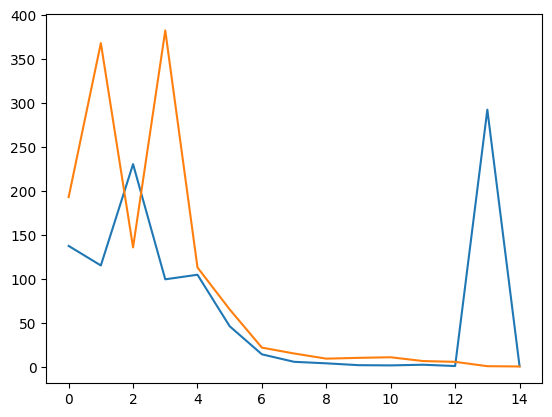

In [46]:
import matplotlib.pyplot as plt
import os

l, tl = [], []
for epoch in range(15):
    loss, test_loss = train_epoch(model, loader, test_loader)
    l.append(loss)
    tl.append(test_loss)
    print(l, tl)
    
plt.plot(l)
plt.plot(tl)
plt.show()

In [48]:
from sklearn.metrics import classification_report

def evaluate(model, test_loader, digits=4):
    model.eval()
    total_test_loss = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index)
            out = out[:batch.batch_size]
            y = batch.type[:batch.batch_size]

            preds = out.argmax(dim=1)
            y_true.append(y.cpu())
            y_pred.append(preds.cpu())
            total_test_loss += F.cross_entropy(out, y).item()
            del batch

    # Flatten all batches
    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()

    return classification_report(y_true, y_pred, digits=digits)


cr = evaluate(model, test_loader)
print("\n🧾 Classification Report:")
print(cr)

  0%|          | 0/55 [00:00<?, ?it/s]

100%|██████████| 55/55 [00:01<00:00, 46.46it/s]


🧾 Classification Report:
              precision    recall  f1-score   support

           0     0.8496    1.0000    0.9187        96
           1     0.5410    0.6600    0.5946        50
           2     0.9263    0.9167    0.9215        96
           3     0.1923    0.1163    0.1449        86
           5     0.9857    0.9934    0.9895      6365
           6     0.5417    0.4149    0.4699        94
           7     0.9595    0.9595    0.9595        74
           8     0.9429    0.8049    0.8684        82
           9     0.8101    0.7273    0.7665        88

    accuracy                         0.9657      7031
   macro avg     0.7499    0.7325    0.7370      7031
weighted avg     0.9612    0.9657    0.9630      7031



### XAI

In [49]:
for c in list(train.type.unique()):
    
    print(
        c, len(train[train.type == c])
    )

5 14531
6 211
8 207
0 197
2 183
9 196
7 177
1 136
3 176
4 4
